###  01 Exploratory Data Analysis

# 🧭 Main EDA — Global Overview of All CSVs

**Goal:** This notebook performs a **global EDA** across all CSV datasets (events, careplan, obs, qresp, support, etc.)  
to understand their **structure**, **quality**, and **relationships**.

It acts as the **master notebook**, serving as the foundation for the upcoming **per-table EDA notebooks**.

**What this notebook does:**
1. Automatically loads all CSVs  
2. Displays structure (rows, columns, data types)  
3. Detects and parses all date/time fields    
4. Provides descriptive statistics and top categories  
5. Checks **relationships between tables** (key coverage)  


In [2]:
# === Imports & Settings ==
from pathlib import Path
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import warnings
from IPython.display import display, HTML

#Remove warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pandas") # To ignore pandas UserWarnings

# 1. Description 

### Careplan : 
Data : "id";"subject";"status";"dateTime";"date";"time";"topic";"description" (not csv)

Explaination : The careplan is a collection of thought and information related to the patient (done most of the time by him) to understand what he can do i difficult time when thinking with discernment is impossible, it is possible to share it with a support person

### Events :
Data :  idsite,iduser,idvisitor,idvisit,visit_starttime,visit_endtime,event_time,id_event_name,event_name,id_event_action,event_action,id_event_category,event_category 

Explaination : The events table relate of all the event that happend in the sero app 

### Observation : 
Data : "id";"subject";"dateTime";"date";"time";"distance";"distanceUnit";"xCoordinate";"xCoordinateUnit";"yCoordinate";"yCoordinateUnit" (not csv)

Explaination : Evalution of risque of suicide with the visual tool PRIMS-S (), that help to understand the level of suicudal risk :  the more distance of the black  circle (suicidal urge) to the yellow circle, the less suicude risk there is

### QuestionnaireResponse : 
Data : "id";"subject";"dateTime";"date";"time";"partOf";"linkId";"answer" (not csv)

Explaination : After PRISM-S exercice, there is 5 question (LinkID : 1.1,1.2,1.3,1.3,1.4,1.5)

     - 1.1 : What does it mean to you that you just placed the black disc there ? 
     - 1.2 : What goes through your mind when you place the disc there ?
     - 1.3 : What do you perceive in the body right now ? 
     - 1.4 : What feeling do you feel when you see the urge to take your life there ? 
     - 1.5 : What's keeping the suicidal urge (black disk) away from you right now ? 

### SupportCareplan 

Data : "id";"subject";"status";"dateTime";"date";"time";"topic";"description" (not csv)

Explaination : The app has two different profile ( affected persons or support persons), this Support careplan is done by the support persons with question like : 

    - What type of activities do i enjoy ? Have i been active today ? 
    - What would i like to leanr ? What helps me discover new things ? 




# 2. Automatically loads all CSVs 

In [3]:

# Paths
RAW = Path("../../data/Raw") # ../ comeback to notebooks -> ../ come to SeroProjectCode -> ../ come to data -> Raw

# Load CSVs
careplan = pd.read_csv(RAW / "SERO-careplan.csv", low_memory=False,sep=";")
events = pd.read_csv(RAW / "SERO-events.csv", low_memory=False)
observation = pd.read_csv(RAW / "SERO-Observations.csv", low_memory=False,sep=";")
Qresp = pd.read_csv(RAW / "SERO-QuestionnaireResponses.csv", low_memory=False,sep=";")
support = pd.read_csv(RAW / "SERO-SupportCareplan.csv", low_memory=False,sep=";")


In [4]:
#dictionnries creation 
tables = {
    "careplan": careplan,
    "events": events,
    "observation": observation,
    "Qresp": Qresp,
    "Support": support
}

for name, df in tables.items():
    print(name, df.shape)

careplan (11398, 8)
events (65803, 13)
observation (1976, 11)
Qresp (6108, 8)
Support (1727, 8)


# 3.Displays structure (rows, columns, data types)


event_category,COUNT,PCT
securityPlan,19710,29.95
roleChoice,15727,23.90
assessment,10096,15.34
contacts,6360,9.67
settings,4304,6.54
resourcePlan,2308,3.51
sharedSecurityPlan,2223,3.38
treasureChest,1775,2.70
information,1685,2.56
sharingSecurityPlan,1615,2.45


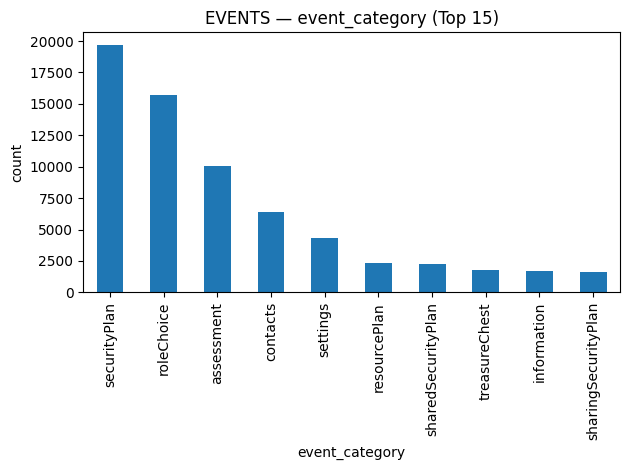

In [5]:
# Descriptive Stats (Tables + Small Charts) ====


def cat_summary(df: pd.DataFrame, col: str, top: int = 20) -> pd.DataFrame:
    """Return a tidy count + percent table for a categorical column."""
    if col not in df.columns:
        return pd.DataFrame({"note": [f"Column '{col}' not found"]})
    vc = df[col].value_counts(dropna=False)
    out = (vc
           .rename("COUNT")
           .to_frame()
           .assign(PCT=lambda x: (x["COUNT"] / x["COUNT"].sum() * 100).round(2))
           .reset_index()
           .rename(columns={"index": col}))
    return out.head(top)

def card(title_html: str, inner_html: str) -> None:
    display(HTML(f"""
    <div style="border:1px solid #ddd;border-radius:10px;margin:10px 0;padding:12px 14px;">
      <div style="font-weight:700;font-size:16px;margin-bottom:8px;">{title_html}</div>
      <div>{inner_html}</div>
    </div>
    """))

# --- EVENTS: event_category ---
events_cat_tbl = cat_summary(events, "event_category", top=20)

card(
    "EVENTS — EVENT_CATEGORY (Top 20)",
    events_cat_tbl.to_html(index=False)
)

# Optional: quick bar chart (top 15)
if "event_category" in events.columns and not events["event_category"].empty:
    top_counts = events["event_category"].value_counts(dropna=False).head(15)
    plt.figure()
    top_counts.plot(kind="bar")
    plt.title("EVENTS — event_category (Top 15)")
    plt.ylabel("count")
    plt.xlabel("event_category")
    plt.tight_layout()
    plt.show()

status,COUNT,PCT
active,11025,96.73
revoked,373,3.27


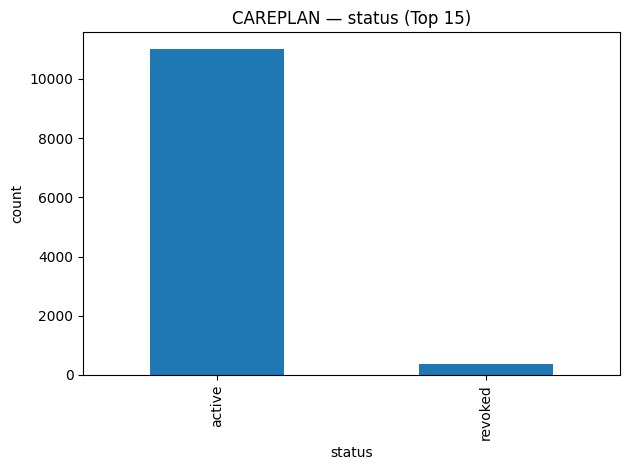

In [6]:
 # --- CAREPLAN: status ---
careplan_status_tbl = cat_summary(careplan, "status", top=20)

card(
    "CAREPLAN — STATUS (Top 20)",
    careplan_status_tbl.to_html(index=False)
)

# Optional: quick bar chart (top)
if "status" in careplan.columns and not careplan["status"].empty:
    top_counts = careplan["status"].value_counts(dropna=False).head(15)
    plt.figure()
    top_counts.plot(kind="bar")
    plt.title("CAREPLAN — status (Top 15)")
    plt.ylabel("count")
    plt.xlabel("status")
    plt.tight_layout()
    plt.show()


,VALUE
count,1948.000
mean,13.918
std,7.753
min,0.000
25%,7.400
50%,13.100
75%,21.700
max,24.900
q00,0.000
q01,0.200


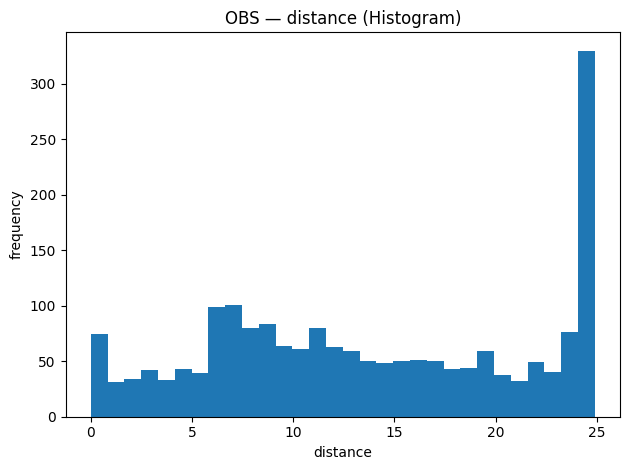

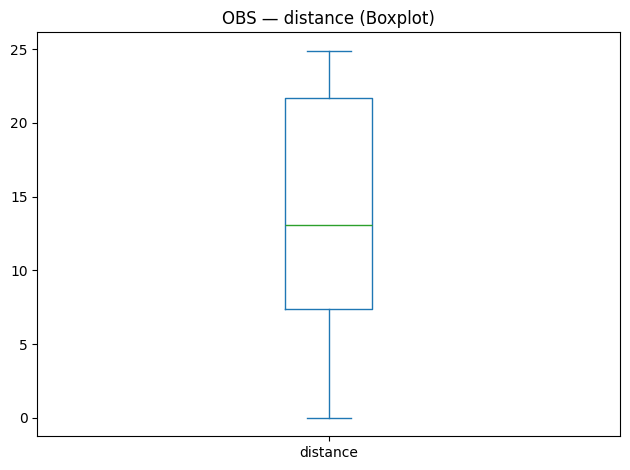

In [7]:
# --- OBSERVATIONS: distance ---
if "distance" in observation.columns:
    # Numeric summary with extra quantiles
    q = observation["distance"].quantile([0, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 1.00]).round(3)
    dist_desc = observation["distance"].describe().round(3).to_frame("VALUE")
    dist_q = q.to_frame("VALUE")
    dist_q.index = dist_q.index.map(lambda x: f"q{int(x*100):02d}")

    card(
        "OBS — DISTANCE (Summary)",
        pd.concat([dist_desc, dist_q]).to_html()
    )

    # Histogram (distribution)
    plt.figure()
    observation["distance"].dropna().plot(kind="hist", bins=30)
    plt.title("OBS — distance (Histogram)")
    plt.xlabel("distance")
    plt.ylabel("frequency")
    plt.tight_layout()
    plt.show()

    # Boxplot (outliers glance)
    plt.figure()
    observation["distance"].dropna().plot(kind="box")
    plt.title("OBS — distance (Boxplot)")
    plt.tight_layout()
    plt.show()
else:
    card("OBS — DISTANCE", "<i>Column 'distance' not found</i>")

In [8]:
# Standardize column names
for df in [careplan, events, observation, Qresp, support]:
    df.columns = df.columns.str.strip().str.lower() #str.strip() remove space between column names

# Summary “at a glance” table (rows, cols, memory, missing %, duplicates, sample columns)
def mem_mb(df): 
    return round(df.memory_usage(deep=True).sum() / 1e6, 2) #memory in MB 

summary_rows = []
for name, df in tables.items():
    summary_rows.append({
        "TABLE": name.upper(),
        "ROWS": len(df),
        "COLS": df.shape[1],
        "MEM_MB": mem_mb(df),
        "MISSING_%(avg)": round(df.isna().mean().mean() * 100, 2) if len(df) else 0.0,
        "DUPLICATES": int(df.duplicated().sum()),
        "DTYPES_SAMPLE": ", ".join(df.dtypes.astype(str).value_counts().head(3).index.tolist()),
        "COLUMNS_SAMPLE": ", ".join(map(str, df.columns[:8])) + (" ..." if df.shape[1] > 8 else "")
    })

summary = pd.DataFrame(summary_rows).sort_values("TABLE").reset_index(drop=True)

# Style: highlight higher missingness, right-align numbers, borders
summary_style = (
    summary
    .style
    .hide(axis="index")
    .set_properties(subset=["ROWS","COLS","MEM_MB","MISSING_%(avg)","DUPLICATES"], **{"text-align": "right"})
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "left"), ("font-weight", "600")]},
        {"selector": "td, th", "props": [("border", "1px solid #ddd"), ("padding", "6px 10px")]},
        {"selector": "table", "props": [("border-collapse", "collapse")]}
    ])
    .background_gradient(subset=["MISSING_%(avg)"], cmap="Reds")
    .format({"MEM_MB": "{:.2f}", "MISSING_%(avg)": "{:.2f}"})
)
summary_style

TABLE,ROWS,COLS,MEM_MB,MISSING_%(avg),DUPLICATES,DTYPES_SAMPLE,COLUMNS_SAMPLE
CAREPLAN,11398,8,6.10,0.00,4,object,"id, subject, status, datetime, date, time, topic, description"
EVENTS,65803,13,36.92,16.51,225,"object, int64, float64","idsite, iduser, idvisitor, idvisit, visit_starttime, visit_endtime, event_time, id_event_name ..."
OBSERVATION,1976,11,1.02,0.77,0,"object, float64","id, subject, datetime, date, time, distance, distanceunit, xcoordinate ..."
QRESP,6108,8,3.10,0.00,0,"object, float64","id, subject, datetime, date, time, partof, linkid, answer"
SUPPORT,1727,8,0.89,0.00,3,object,"id, subject, status, datetime, date, time, topic, description"


We can see that there is 16% of missing value in Events table and a bit also in Obs table, so we want to check what type of column have missing value

## 3.1 Missing Value check 

Tables with missing values: ['events', 'observation']


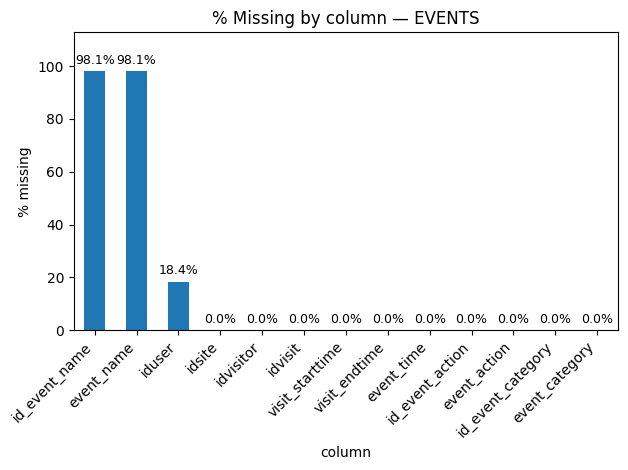

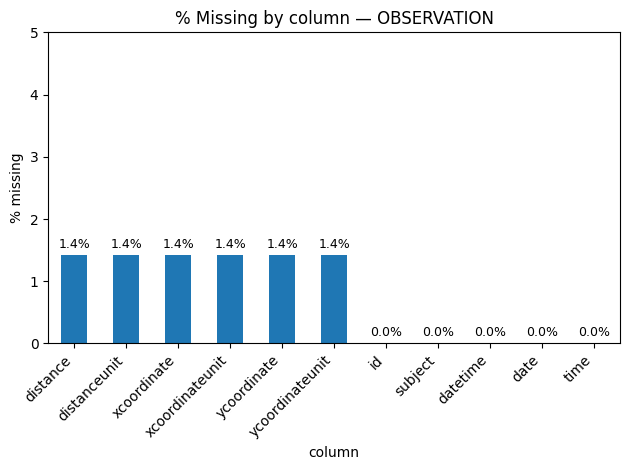

In [9]:
# Keep only the tables that actually have at least one missing value
df_missing = {name: df for name, df in tables.items() if df.isna().any().any()}

# Quick check
print("Tables with missing values:", list(df_missing.keys()))

# Plot missingness with % labels on each bar
for name, df in df_missing.items():
    miss = df.isna().mean().mul(100).sort_values(ascending=False)
    if miss.empty:
        continue

    fig, ax = plt.subplots()
    ax = miss.plot(kind="bar", ax=ax)

    # Title & axes
    ax.set_title(f"% Missing by column — {name.upper()}")
    ax.set_ylabel("% missing")
    ax.set_xlabel("column")

    # Rotate x labels for readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    # Add exact % labels above each bar
    for patch, (_, val) in zip(ax.patches, miss.items()):
        ax.annotate(
            f"{val:.1f}%",
            (patch.get_x() + patch.get_width() / 2, patch.get_height()),
            ha="center", va="bottom",
            xytext=(0, 3), textcoords="offset points",
            fontsize=9
        )

    # Nice top padding
    ax.set_ylim(0, max(miss.max() * 1.15, 5))

    plt.tight_layout()
    plt.show()


For **EVENTS** is a lot of data missing in the id_event_name and event_name, the pourcentage are the same, we can think that those two are completly correlated during creation, it seems that iduser are also missing close to 20% of the value 

For **OBS** it seems that :

 - distance
 - distanceunit
 - xcoordinate
 - xcoordinateunit
 - ycoordinate
 - ycoordinateunit

 
Are missing, it seems like it's all related to the distance to "suicide idea" function --> maybe people that forgot to answer ? 


## 3.2 Check of the table forms 

In [10]:

display(summary_style)

for name, df in tables.items():
    display(HTML(f"""
    <div style="border:1px solid #ddd;border-radius:10px;margin:10px 0;padding:10px 14px;">
        <div style="font-weight:700;font-size:16px;margin-bottom:6px;">
            {name.upper()}
        </div>
        <div>{df.head(5).to_html(index=False)}</div>
    </div>
    """))
    

 

TABLE,ROWS,COLS,MEM_MB,MISSING_%(avg),DUPLICATES,DTYPES_SAMPLE,COLUMNS_SAMPLE
CAREPLAN,11398,8,6.10,0.00,4,object,"id, subject, status, datetime, date, time, topic, description"
EVENTS,65803,13,36.92,16.51,225,"object, int64, float64","idsite, iduser, idvisitor, idvisit, visit_starttime, visit_endtime, event_time, id_event_name ..."
OBSERVATION,1976,11,1.02,0.77,0,"object, float64","id, subject, datetime, date, time, distance, distanceunit, xcoordinate ..."
QRESP,6108,8,3.10,0.00,0,"object, float64","id, subject, datetime, date, time, partof, linkid, answer"
SUPPORT,1727,8,0.89,0.00,3,object,"id, subject, status, datetime, date, time, topic, description"


id,subject,status,datetime,date,time,topic,description
P1b74f01ed5f203e72573fef1dac68297add797e0,P-87EG-KFEL,active,2024-11-05T15:44:36.862Z,2024-11-05,15:44:36,motivation,Freundeskreis
P1b74f01ed5f203e72573fef1dac68297add797e0,P-87EG-KFEL,active,2024-11-05T15:44:36.862Z,2024-11-05,15:44:36,warningSigns,"trauer, angst"
P1b74f01ed5f203e72573fef1dac68297add797e0,P-87EG-KFEL,active,2024-11-05T15:44:36.862Z,2024-11-05,15:44:36,copingStrategies,Kochen
P1b74f01ed5f203e72573fef1dac68297add797e0,P-87EG-KFEL,active,2024-11-05T15:44:36.862Z,2024-11-05,15:44:36,copingStrategies,wandern
P1b74f01ed5f203e72573fef1dac68297add797e0,P-87EG-KFEL,active,2024-11-05T15:44:36.862Z,2024-11-05,15:44:36,copingStrategies,singen


idsite,iduser,idvisitor,idvisit,visit_starttime,visit_endtime,event_time,id_event_name,event_name,id_event_action,event_action,id_event_category,event_category
6,550219131862241a69e5d5a76643e1f00f32227a3249c7bd2f87875e308bc84d,477E71E26D09D23A,12265,2023-04-22 17:03:51,2023-04-22 17:04:35,2023-04-22 17:03:51,NaN,NaN,603,view_current,578,securityPlan
6,550219131862241a69e5d5a76643e1f00f32227a3249c7bd2f87875e308bc84d,477E71E26D09D23A,12265,2023-04-22 17:03:51,2023-04-22 17:04:35,2023-04-22 17:04:23,NaN,NaN,635,view_tutorial,578,securityPlan
6,550219131862241a69e5d5a76643e1f00f32227a3249c7bd2f87875e308bc84d,477E71E26D09D23A,12265,2023-04-22 17:03:51,2023-04-22 17:04:35,2023-04-22 17:04:35,NaN,NaN,603,view_current,578,securityPlan
6,b9e5c1b189856f5f7ab1e896f8347d48de93eb523c940b3b8f4e93a3df49a8a1,4A640021B665D756,12568,2023-04-26 13:18:03,2023-04-26 13:19:00,2023-04-26 13:18:03,NaN,NaN,624,call_proJuventute,566,contacts
6,b9e5c1b189856f5f7ab1e896f8347d48de93eb523c940b3b8f4e93a3df49a8a1,4A640021B665D756,12568,2023-04-26 13:18:03,2023-04-26 13:19:00,2023-04-26 13:18:07,NaN,NaN,615,call_dieDargeboteneHand,566,contacts


id,subject,datetime,date,time,distance,distanceunit,xcoordinate,xcoordinateunit,ycoordinate,ycoordinateunit
P281d973a48dc96616df59380f31b5921ec43bd46,P-87EG-KFEL,2024-11-05T15:47:12.000Z,2024-11-05,15:47:12,3.2,cm,21.5,cm,13.2,cm
P2effc9a24a8b816cfcdd2b9f3b846913c5e15b4e,P-87EG-KFEL,2024-11-05T15:57:11.766Z,2024-11-05,15:57:11,NaN,NaN,NaN,NaN,NaN,NaN
Pbddaaa06ec21bb7fa59602b157bda257720de6d7,P-87EG-KFEL,2024-11-05T19:05:03.403Z,2024-11-05,19:05:03,9.0,cm,14.9,cm,16.0,cm
Pe60ba3aca2bcff5958b646dac4f80afb7fce945c,P-87EG-KFEL,2024-11-05T19:05:53.259Z,2024-11-05,19:05:53,9.2,cm,14.9,cm,13.5,cm
P77a46c74e00d502303e23ffc0378fd465d45d1ad,P-87EG-KFEL,2024-11-07T08:38:24.591Z,2024-11-07,08:38:24,7.2,cm,25.6,cm,8.3,cm


id,subject,datetime,date,time,partof,linkid,answer
P5286177188adc09b41ec1fc4a0a023c5862ec09d,P-87EG-KFEL,2024-11-05T15:47:12.000Z,2024-11-05,15:47:12,672a3e00bd2fa86b213da4a1,1.1,Grosse Verunsicherung
P5286177188adc09b41ec1fc4a0a023c5862ec09d,P-87EG-KFEL,2024-11-05T15:47:12.000Z,2024-11-05,15:47:12,672a3e00bd2fa86b213da4a1,2.1,Suizid
P5286177188adc09b41ec1fc4a0a023c5862ec09d,P-87EG-KFEL,2024-11-05T15:47:12.000Z,2024-11-05,15:47:12,672a3e00bd2fa86b213da4a1,3.1,Wärme im Bauch
P5286177188adc09b41ec1fc4a0a023c5862ec09d,P-87EG-KFEL,2024-11-05T15:47:12.000Z,2024-11-05,15:47:12,672a3e00bd2fa86b213da4a1,4.1,Angst
P5286177188adc09b41ec1fc4a0a023c5862ec09d,P-87EG-KFEL,2024-11-05T15:47:12.000Z,2024-11-05,15:47:12,672a3e00bd2fa86b213da4a1,5.1,das app


id,subject,status,datetime,date,time,topic,description
P6b00fc945589791e09e163704e7ceedce1d0d56b,P-A32T-E5KH,active,2025-05-21T11:33:12.293Z,2025-05-21,11:33:12,newLearning,Dokumentationen
P6b00fc945589791e09e163704e7ceedce1d0d56b,P-A32T-E5KH,active,2025-05-21T11:33:12.293Z,2025-05-21,11:33:12,newLearning,Geschichte
P6b00fc945589791e09e163704e7ceedce1d0d56b,P-A32T-E5KH,active,2025-05-21T11:33:12.293Z,2025-05-21,11:33:12,newLearning,Prozesse
P6b00fc945589791e09e163704e7ceedce1d0d56b,P-A32T-E5KH,active,2025-05-21T11:33:12.293Z,2025-05-21,11:33:12,creativity,"Kochen, neue Rezepte"
P6b00fc945589791e09e163704e7ceedce1d0d56b,P-A32T-E5KH,active,2025-05-21T11:33:12.293Z,2025-05-21,11:33:12,creativity,Gärtnern


**Note the different type of Dtype of the csv data (object,int64, float64)**


# 4. Detects and parses all date/time fields  
 ### 4.1Fonctions 
 

In [11]:
# === Cleaning utilities ===

def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    new_cols = []
    for c in df.columns:
        c2 = str(c).strip().lower()  # Lowercase and strip spaces
        c2 = re.sub(r"[\s\-/]+", "_", c2)   # Replace spaces, dashes, slashes with underscores
        c2 = re.sub(r"[^0-9a-zA-Z_]", "", c2) # Remove special characters 
        new_cols.append(c2)
    df.columns = new_cols
    return df


# ------------------------------------------------------------------------------------------------------

DATE_TOKENS = ("date", "time", "datetime", "timestamp", "period", "start", "end")
    
def find_date_columns(df: pd.DataFrame):
    cols = []
    for c in df.columns:
        lc = c.lower()
        if any(tok in lc for tok in DATE_TOKENS): # check if any of the date tokens are in the column name
            cols.append(c)
    return sorted(set(cols)) # return the columns found with possible date info

# ------------------------------------------------------------------------------------------------

def parse_dates_inplace(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    report = []
    for c in cols:
        na_before = df[c].isna().sum() if c in df.columns else None # get number of NA before parsing
        try:
            df[c] = pd.to_datetime(df[c], errors="coerce", utc=True, infer_datetime_format=True) # parse dates
            na_after = df[c].isna().sum() # get number of NA after parsing
            report.append((c, na_before, na_after, str(df[c].dtype))) # append report info
        except Exception as e:
            report.append((c, na_before, None, f"FAILED: {e}")) # append report info in case of failure
    rep_df = pd.DataFrame(report, columns=["column", "na_before", "na_after", "dtype/notes"])  # create report dataframe (Na_before : number of missing value  before parsing, Na_after : number of missing value after parsing,dtype/notes : datatype after parsing)
    return rep_df

# ------------------------------------------------------------------------------------------------

def drop_empty_columns(df: pd.DataFrame) -> list:
    empty_cols = [c for c in df.columns if df[c].isna().all()]
    if empty_cols:
        df.drop(columns=empty_cols, inplace=True)
    return empty_cols     # Drops columns that are entirely empty (NaN) and returns their names


 

### 4.2 Parsing 

In [12]:

# === Apply cleaning & date parsing per table ===
clean_reports = {}
empty_cols_dropped = {}

import warnings

for name, df in tables.items():
    tables[name] = standardize_columns(df)
    df = tables[name]
    removed = drop_empty_columns(df)
    if removed:
        empty_cols_dropped[name] = removed
    date_cols = find_date_columns(df)

    # Silence ONLY during parsing
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            category=UserWarning,
            message=r".*(infer_datetime_format|Could not infer format).*",
        )
        rep = parse_dates_inplace(df, date_cols)

    clean_reports[name] = {
        "date_columns_detected": date_cols,
        "date_parse_report ": rep
    }

print("Dropped 100% empty columns (by table):")
print(empty_cols_dropped if empty_cols_dropped else "None")

# Example report
for name, rep in clean_reports.items():
    print(f"\n=== {name} — date parse report ===")
    display(rep)

Dropped 100% empty columns (by table):
None

=== careplan — date parse report ===


{'date_columns_detected': ['date', 'datetime', 'time'],
 'date_parse_report ':      column  na_before  na_after          dtype/notes
 0      date          0         0  datetime64[ns, UTC]
 1  datetime          0         0  datetime64[ns, UTC]
 2      time          0         0  datetime64[ns, UTC]}


=== events — date parse report ===


{'date_columns_detected': ['event_time', 'visit_endtime', 'visit_starttime'],
 'date_parse_report ':             column  na_before  na_after          dtype/notes
 0       event_time          0         0  datetime64[ns, UTC]
 1    visit_endtime          0         0  datetime64[ns, UTC]
 2  visit_starttime          0         0  datetime64[ns, UTC]}


=== observation — date parse report ===


{'date_columns_detected': ['date', 'datetime', 'time'],
 'date_parse_report ':      column  na_before  na_after          dtype/notes
 0      date          0         0  datetime64[ns, UTC]
 1  datetime          0         0  datetime64[ns, UTC]
 2      time          0         0  datetime64[ns, UTC]}


=== Qresp — date parse report ===


{'date_columns_detected': ['date', 'datetime', 'time'],
 'date_parse_report ':      column  na_before  na_after          dtype/notes
 0      date          0         0  datetime64[ns, UTC]
 1  datetime          0         0  datetime64[ns, UTC]
 2      time          0         0  datetime64[ns, UTC]}


=== Support — date parse report ===


{'date_columns_detected': ['date', 'datetime', 'time'],
 'date_parse_report ':      column  na_before  na_after          dtype/notes
 0      date          0         0  datetime64[ns, UTC]
 1  datetime          0         0  datetime64[ns, UTC]
 2      time          0         0  datetime64[ns, UTC]}

### Our report shows that the columns date, datetime, and time were successfully converted without any data loss and are now in the format datetime64[ns, UTC].
No errors or warnings occurred (they were filtered), so everything is clean and consistent.

⚠️ A subtle point: if a column contains only time values (e.g., "14:30"), pd.to_datetime will create a full datetime by adding a default date (usually the current date at the time of execution). Since you set utc=True, everything is localized to UTC.
If you want to keep only the time component after parsing, you can extract it using df['time'].dt.time, or simply keep the original column before the conversion.

--> We will need to drop it


### Check after parsing 

In [13]:

def mem_mb(df): 
    return round(df.memory_usage(deep=True).sum() / 1e6, 2) #memory in MB 

summary_rows = []
for name, df in tables.items():
    summary_rows.append({
        "TABLE": name.upper(),
        "ROWS": len(df),
        "COLS": df.shape[1],
        "DTYPES_SAMPLE": ", ".join(df.dtypes.astype(str).value_counts().head(3).index.tolist()),
        "COLUMNS_SAMPLE": ", ".join(map(str, df.columns[:8])) + (" ..." if df.shape[1] > 8 else "")
    })

summary = pd.DataFrame(summary_rows).sort_values("TABLE").reset_index(drop=True)

# Style: highlight higher missingness, right-align numbers, borders
summary_style = (
    summary
    .style
    .hide(axis="index")
    .set_properties(subset=["ROWS","COLS"], **{"text-align": "right"})
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "left"), ("font-weight", "600")]},
        {"selector": "td, th", "props": [("border", "1px solid #ddd"), ("padding", "6px 10px")]},
        {"selector": "table", "props": [("border-collapse", "collapse")]}
    ])
)
summary_style

display(summary_style)

for name, df in tables.items():
    display(HTML(f"""
    <div style="border:1px solid #ddd;border-radius:10px;margin:10px 0;padding:10px 14px;">
        <div style="font-weight:700;font-size:16px;margin-bottom:6px;">
            {name.upper()}
        </div>
        <div>{df.head(5).to_html(index=False)}</div>
    </div>
    """))

TABLE,ROWS,COLS,DTYPES_SAMPLE,COLUMNS_SAMPLE
CAREPLAN,11398,8,"object, datetime64[ns, UTC]","id, subject, status, datetime, date, time, topic, description"
EVENTS,65803,13,"object, int64, datetime64[ns, UTC]","idsite, iduser, idvisitor, idvisit, visit_starttime, visit_endtime, event_time, id_event_name ..."
OBSERVATION,1976,11,"object, datetime64[ns, UTC], float64","id, subject, datetime, date, time, distance, distanceunit, xcoordinate ..."
QRESP,6108,8,"object, datetime64[ns, UTC], float64","id, subject, datetime, date, time, partof, linkid, answer"
SUPPORT,1727,8,"object, datetime64[ns, UTC]","id, subject, status, datetime, date, time, topic, description"


id,subject,status,datetime,date,time,topic,description
P1b74f01ed5f203e72573fef1dac68297add797e0,P-87EG-KFEL,active,2024-11-05 15:44:36.862000+00:00,2024-11-05 00:00:00+00:00,2025-12-18 15:44:36+00:00,motivation,Freundeskreis
P1b74f01ed5f203e72573fef1dac68297add797e0,P-87EG-KFEL,active,2024-11-05 15:44:36.862000+00:00,2024-11-05 00:00:00+00:00,2025-12-18 15:44:36+00:00,warningSigns,"trauer, angst"
P1b74f01ed5f203e72573fef1dac68297add797e0,P-87EG-KFEL,active,2024-11-05 15:44:36.862000+00:00,2024-11-05 00:00:00+00:00,2025-12-18 15:44:36+00:00,copingStrategies,Kochen
P1b74f01ed5f203e72573fef1dac68297add797e0,P-87EG-KFEL,active,2024-11-05 15:44:36.862000+00:00,2024-11-05 00:00:00+00:00,2025-12-18 15:44:36+00:00,copingStrategies,wandern
P1b74f01ed5f203e72573fef1dac68297add797e0,P-87EG-KFEL,active,2024-11-05 15:44:36.862000+00:00,2024-11-05 00:00:00+00:00,2025-12-18 15:44:36+00:00,copingStrategies,singen


idsite,iduser,idvisitor,idvisit,visit_starttime,visit_endtime,event_time,id_event_name,event_name,id_event_action,event_action,id_event_category,event_category
6,550219131862241a69e5d5a76643e1f00f32227a3249c7bd2f87875e308bc84d,477E71E26D09D23A,12265,2023-04-22 17:03:51+00:00,2023-04-22 17:04:35+00:00,2023-04-22 17:03:51+00:00,NaN,NaN,603,view_current,578,securityPlan
6,550219131862241a69e5d5a76643e1f00f32227a3249c7bd2f87875e308bc84d,477E71E26D09D23A,12265,2023-04-22 17:03:51+00:00,2023-04-22 17:04:35+00:00,2023-04-22 17:04:23+00:00,NaN,NaN,635,view_tutorial,578,securityPlan
6,550219131862241a69e5d5a76643e1f00f32227a3249c7bd2f87875e308bc84d,477E71E26D09D23A,12265,2023-04-22 17:03:51+00:00,2023-04-22 17:04:35+00:00,2023-04-22 17:04:35+00:00,NaN,NaN,603,view_current,578,securityPlan
6,b9e5c1b189856f5f7ab1e896f8347d48de93eb523c940b3b8f4e93a3df49a8a1,4A640021B665D756,12568,2023-04-26 13:18:03+00:00,2023-04-26 13:19:00+00:00,2023-04-26 13:18:03+00:00,NaN,NaN,624,call_proJuventute,566,contacts
6,b9e5c1b189856f5f7ab1e896f8347d48de93eb523c940b3b8f4e93a3df49a8a1,4A640021B665D756,12568,2023-04-26 13:18:03+00:00,2023-04-26 13:19:00+00:00,2023-04-26 13:18:07+00:00,NaN,NaN,615,call_dieDargeboteneHand,566,contacts


id,subject,datetime,date,time,distance,distanceunit,xcoordinate,xcoordinateunit,ycoordinate,ycoordinateunit
P281d973a48dc96616df59380f31b5921ec43bd46,P-87EG-KFEL,2024-11-05 15:47:12+00:00,2024-11-05 00:00:00+00:00,2025-12-18 15:47:12+00:00,3.2,cm,21.5,cm,13.2,cm
P2effc9a24a8b816cfcdd2b9f3b846913c5e15b4e,P-87EG-KFEL,2024-11-05 15:57:11.766000+00:00,2024-11-05 00:00:00+00:00,2025-12-18 15:57:11+00:00,NaN,NaN,NaN,NaN,NaN,NaN
Pbddaaa06ec21bb7fa59602b157bda257720de6d7,P-87EG-KFEL,2024-11-05 19:05:03.403000+00:00,2024-11-05 00:00:00+00:00,2025-12-18 19:05:03+00:00,9.0,cm,14.9,cm,16.0,cm
Pe60ba3aca2bcff5958b646dac4f80afb7fce945c,P-87EG-KFEL,2024-11-05 19:05:53.259000+00:00,2024-11-05 00:00:00+00:00,2025-12-18 19:05:53+00:00,9.2,cm,14.9,cm,13.5,cm
P77a46c74e00d502303e23ffc0378fd465d45d1ad,P-87EG-KFEL,2024-11-07 08:38:24.591000+00:00,2024-11-07 00:00:00+00:00,2025-12-18 08:38:24+00:00,7.2,cm,25.6,cm,8.3,cm


id,subject,datetime,date,time,partof,linkid,answer
P5286177188adc09b41ec1fc4a0a023c5862ec09d,P-87EG-KFEL,2024-11-05 15:47:12+00:00,2024-11-05 00:00:00+00:00,2025-12-18 15:47:12+00:00,672a3e00bd2fa86b213da4a1,1.1,Grosse Verunsicherung
P5286177188adc09b41ec1fc4a0a023c5862ec09d,P-87EG-KFEL,2024-11-05 15:47:12+00:00,2024-11-05 00:00:00+00:00,2025-12-18 15:47:12+00:00,672a3e00bd2fa86b213da4a1,2.1,Suizid
P5286177188adc09b41ec1fc4a0a023c5862ec09d,P-87EG-KFEL,2024-11-05 15:47:12+00:00,2024-11-05 00:00:00+00:00,2025-12-18 15:47:12+00:00,672a3e00bd2fa86b213da4a1,3.1,Wärme im Bauch
P5286177188adc09b41ec1fc4a0a023c5862ec09d,P-87EG-KFEL,2024-11-05 15:47:12+00:00,2024-11-05 00:00:00+00:00,2025-12-18 15:47:12+00:00,672a3e00bd2fa86b213da4a1,4.1,Angst
P5286177188adc09b41ec1fc4a0a023c5862ec09d,P-87EG-KFEL,2024-11-05 15:47:12+00:00,2024-11-05 00:00:00+00:00,2025-12-18 15:47:12+00:00,672a3e00bd2fa86b213da4a1,5.1,das app


id,subject,status,datetime,date,time,topic,description
P6b00fc945589791e09e163704e7ceedce1d0d56b,P-A32T-E5KH,active,2025-05-21 11:33:12.293000+00:00,2025-05-21 00:00:00+00:00,2025-12-18 11:33:12+00:00,newLearning,Dokumentationen
P6b00fc945589791e09e163704e7ceedce1d0d56b,P-A32T-E5KH,active,2025-05-21 11:33:12.293000+00:00,2025-05-21 00:00:00+00:00,2025-12-18 11:33:12+00:00,newLearning,Geschichte
P6b00fc945589791e09e163704e7ceedce1d0d56b,P-A32T-E5KH,active,2025-05-21 11:33:12.293000+00:00,2025-05-21 00:00:00+00:00,2025-12-18 11:33:12+00:00,newLearning,Prozesse
P6b00fc945589791e09e163704e7ceedce1d0d56b,P-A32T-E5KH,active,2025-05-21 11:33:12.293000+00:00,2025-05-21 00:00:00+00:00,2025-12-18 11:33:12+00:00,creativity,"Kochen, neue Rezepte"
P6b00fc945589791e09e163704e7ceedce1d0d56b,P-A32T-E5KH,active,2025-05-21 11:33:12.293000+00:00,2025-05-21 00:00:00+00:00,2025-12-18 11:33:12+00:00,creativity,Gärtnern


We can see that the column 'time' has been converted to datetime64[ns, UTC] but all values are related to the time of day only (e.g., "14:30"), resulting in full datetimes with a default date.